In [50]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [212]:
#standard imports
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

#let's import the SVM classifier
from sklearn.svm import LinearSVC

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
import utils; reload(utils)
from utils import featurewise_norm, spearman_brown


In [239]:
#ok let's load the neural data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

## Human Behavioral Dataset

In [405]:
#and also let's load some behavioral data
HUMAN_DATA_PATH = "/mnt/data3/yamins/visual/human_behavior.hdf5"
Behavioral_Dataset = h5py.File(HUMAN_DATA_PATH)

In [213]:
#let's explore the behavorial data a little
Behavioral_Dataset.keys()
#OK -- each of these 9 keys corresponds to an experiment
#humans were asked to do 8-way alternative forced choice (AFC) tasks
#one of these experiments (Basic_categorization) is where the humans
#were choosing the *category* of object shown in an image out of the 8
#unique categories.  For the other 8 tasks, the humans were supposed to 
#indicate which *object* was shown, within the indicated class.  E.g. 
#Animals_identification meant that the idea was identify which of 8 
#animals was shown in the image.

[u'Animals_identification',
 u'Basic_categorization',
 u'Boats_identification',
 u'Cars_identification',
 u'Chairs_identification',
 u'Faces_identification',
 u'Fruits_identification',
 u'Planes_identification',
 u'Tables_identification']

In [406]:
#What are the keys within each experiment?
Behavioral_Dataset['Basic_categorization'].keys()
#ok there appear to be things related to the individuals choice ('chosen'), the 
#ground true ("actual"), the reaction time, and image variation level

[u'actual', u'chosen', u'image_id', u'reaction_time', u'variation_level']

In [407]:
#what's in each of these keys?
Behavioral_Dataset['Basic_categorization']['actual']
#ah, so "actual" is an array dataset

<HDF5 dataset "actual": shape (80, 192), type "|S7">

In [217]:
#what are its dimensions?
Behavioral_Dataset['Basic_categorization']['actual'].dims.keys()
#ok, apparently subect x trial

[<"subject" dimension 0 of HDF5 dataset at 139632598381104>,
 <"trial" dimension 1 of HDF5 dataset at 139632598381104>]

In [219]:
#what do the actual labels look like? 
Behavioral_Dataset['Basic_categorization']['actual'][0][:10]
#ok they're category labels, that's reasonable if this was a 
#categorization task

array(['Chairs', 'Boats', 'Fruits', 'Faces', 'Cars', 'Planes', 'Chairs',
       'Cars', 'Fruits', 'Animals'],
      dtype='|S7')

In [220]:
Behavioral_Dataset['Basic_categorization']['chosen'][0][:10]

array(['Chairs', 'Boats', 'Fruits', 'Faces', 'Cars', 'Planes', 'Chairs',
       'Cars', 'Fruits', 'Animals'],
      dtype='|S7')

In [408]:
Behavioral_Dataset['Animals_identification']['chosen'][0][:10]

array(['hedgehog', 'GORILLA', 'bear', 'blCow', 'blCow', 'ELEPHANT_M',
       'bear', 'GORILLA', 'breed_pug', 'breed_pug'],
      dtype='|S10')

In [245]:
#ok so we see that for each experiment, we have data arrays for 
#"actual", "chosen", "reaction_time" and "variation_level" among things
#these arrays of of the form of (subject, trial) for different subjects and trials
#within that subject

In [225]:
#how good are the subjects at these tasks?
chosen = Behavioral_Dataset['Basic_categorization']['chosen'][:]
actual = Behavioral_Dataset['Basic_categorization']['actual'][:]
percent_correct = (chosen == actual).mean() * 100
print('The subjects achieved mean accuracy of %.2f%% on basic categorization' % percent_correct)

The subjects achieved mean accuracy of 88.38% on basic categorization


In [410]:
#ok let's get the confusion matrices for each part of the dat
#by variation level for all experiments

expnames = [('Basic_categorization', 'category')] + \
            [(c + '_identification', 'obj') for c in unique_categories]
    
human_confmats = {}
for expname, exp_goal in expnames:
    if 'Basic' in expname:
        ucats = unique_categories
    else:
        catn = expname.split('_')[0]
        ucats = objects_by_category[catn]
    preds = Behavioral_Dataset[expname]['chosen']
    actuals = Behavioral_Dataset[expname]['actual']
    vls = Behavioral_Dataset[expname]['variation_level']
    cms = np.array([metrics.get_confusion_matrix(p, a, ucats) for p, a in zip(preds, actuals)])
    human_confmats[(expname, 'all')] = cms
    for v in ['V0', 'V3', 'V6']:
        cms = np.array([metrics.get_confusion_matrix(p[vl==v], a[vl==v], ucats) 
                             for p, a, vl in zip(preds, actuals, vls)])
        human_confmats[(expname, v)] = cms
                     

In [411]:
cmat = human_confmats[('Basic_categorization', 'V0')]
cmat.shape
#ok we've gathered the confusion matrices so that the 0th axis 
#is the subject dimension

(80, 8, 8)

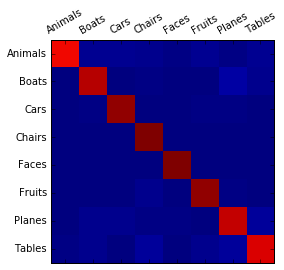

In [412]:
#What does the confusion matrix look like? 
plt.matshow(cmat.mean(0))
plt.xticks(range(8), unique_categories, rotation=30);
plt.yticks(range(8), unique_categories);

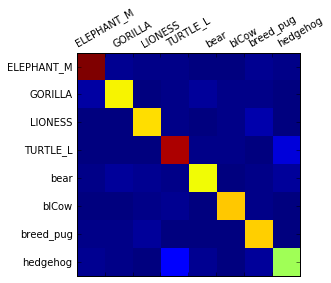

In [413]:
#ok, subordinate identification at V3 is harder:
cmat = human_confmats[('Animals_identification', 'V3')]
plt.matshow(cmat.mean(0))
plt.xticks(np.arange(8)+.5, objects_by_category['Animals'], rotation=30);
plt.yticks(range(8), objects_by_category['Animals']);

### Split-half reliability of human data

In [415]:
def get_dprimes(keys, results=None, confmats=None):
    """extracts dprimes from results
    """
    dprimes = []
    for k in keys:
        if confmats is None:
            expname, vl = k
            cmat = results[expname][vl][0]['test']['confusion_matrices']
        else:
            cmat = confmats[k]

        dp = metrics.dprime_confmat(cmat.mean(0))
        dprimes.extend(dp)
    return dprimes

In [416]:
keys = human_confmats.keys()
d_human = get_dprimes(keys, confmats=human_confmats)

len(d_human)
#There are 288 overall task points here

288

In [417]:
#what do the d-prime values look like? 
print(np.max(d_human), np.min(d_human))
d_human[:10]

(10.0, -0.27753794633323281)


[3.2610207344528197,
 2.8027049409436184,
 2.7056856080058722,
 4.0115634810984204,
 3.7612749373734005,
 4.1891691647178391,
 3.262731147300626,
 4.3431821952763929,
 2.6812870164452627,
 2.1244318651375025]

In [418]:
def idfunc(x):
    return x

def pearsonr(a, b):
    return stats.pearsonr(a, b)[0]

def split_half_correlation(datas_by_trial,
                           num_splits,
                           aggfunc=idfunc,
                           statfunc=pearsonr):
    """
    Similar to split-half calculation from lecture 2, 
    but now allowing various aggregation and statistical comparison 
    functions
    """
        
    random_number_generator = np.random.RandomState(seed=0)

    corrvals = []
    for split_index in range(num_splits):
        stats1 = []
        stats2 = []
        for data in datas_by_trial:
            #get total number of trials
            num_trials = data.shape[0]

            #construct a new permutation of the trial indices
            perm = random_number_generator.permutation(num_trials)

            #take the first num_trials/2 and second num_trials/2 pieces of the data
            first_half_of_trial_indices = perm[:num_trials / 2]
            second_half_of_trial_indices = perm[num_trials / 2: num_trials]

            #mean over trial dimension
            s1 = aggfunc(data[first_half_of_trial_indices].mean(axis=0))
            s2 = aggfunc(data[second_half_of_trial_indices].mean(axis=0))
            stats1.extend(s1)
            stats2.extend(s2)
        
        #compute the correlation between the means
        corrval = statfunc(np.array(stats1), 
                           np.array(stats2))
        #add to the list
        corrvals.append(corrval)
        
    return spearman_brown(np.array(corrvals), 2)

In [419]:
#Ok so oftentimes the reliability is pretty good
correlations = split_half_correlation(
                       [human_confmats[('Basic_categorization', 'V3')]],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
correlations.mean()

0.96674195442796285

In [420]:
#sometimes it's a bit less
correlations = split_half_correlation(
                       [human_confmats[('Boats_identification', 'V3')]],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
correlations.mean()

0.64796209850972064

In [421]:
#obviously pretty poor for a few especially confusing tasks
correlations = split_half_correlation(
                       [human_confmats[('Faces_identification', 'V0')]],
                       num_splits=500, 
                       aggfunc=metrics.dprime_confmat)
correlations.mean()

-0.44250655513222925

In [381]:
def rsquared(v1, v2):
    w, b, r, p, ser = stats.linregress(v1, v2)
    return r**2

In [390]:
correlations = split_half_correlation(
                       [human_confmats[('Basic_categorization', 'V3')]],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat,
                       statfunc=rsquared)
correlations.mean()

0.93366044208152343

In [376]:
def get_split_half_from_cmatdict(confmat_dict, ks):
    #compute reliability using correlation metric
    corrvals = split_half_correlation([confmat_dict[k] for k in ks],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat)
    
    #compute reliabiliy using rsquared metric
    rsquareds = split_half_correlation([confmat_dict[k] for k in ks],
                       num_splits=100, 
                       aggfunc=metrics.dprime_confmat,
                       statfunc=rsquared)
    return corrvals.mean(), rsquareds.mean()

In [422]:
#ok so let's look dprime reliabilities
#across many tasks
human_splithalf = get_split_half_from_cmatdict(human_confmats, keys) 

In [423]:
#correlation split half is pretty high
human_splithalf[0]

0.90534288773244453

In [424]:
#rsquared split half is consistent
human_splithalf[1]

0.81255470525497164

## Getting Classifier Decoding Results

In [151]:
pretty_good_cval = 1e-3
var_levels = ['all', 'V0', 'V3', 'V6']
        
def get_splits_and_labels(expname, exp_goal, vl):
    num_test = 10
    if vl == 'V0':
        num_test = 7
        num_train = 10 - num_test
    elif vl in ['V3', 'V6']:
        num_train = 40 - num_test
    else:
        num_train = 90 - num_test
    if exp_goal == 'category':
        if vl == 'all':
            train_filter = None
            test_filter = None
        else:
            train_filter = lambda x: (x['variation_level'] == vl)
            test_filter = lambda x: (x['variation_level'] == vl)

        labels = meta_array['category']
    else:
        catn = expname.split('_')[0]
        if vl == 'all':
            train_filter = lambda x: (x['category'] == catn)
            test_filter = lambda x: (x['category'] == catn)
        else:
            train_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)
            test_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)

        labels = meta_array['object_name']
        
    splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=num_test,  
                           num_per_class_train=num_train,
                           train_filter=train_filter,
                           test_filter=test_filter
                           )
   
    return splits, labels
    


In [323]:
def tabulate_results(features, model_type,
                     model_args=None, gridcv_params=None,
                     toprint=False):
    """
    Trains and gets results for whatever desired model type
    for all the different tasks in the task battery
    """
    results = {}
    for expname, exp_goal in expnames:
        results[expname] = {}
        for vl in var_levels:
            if toprint:
                print('Getting results for %s %s' % (expname, vl))
            splits, labels = get_splits_and_labels(expname, exp_goal, vl)
            results[expname][vl] = cv.train_and_test_scikit_classifier(features=features, 
                                         labels=labels,
                                         splits=splits,
                                         model_class=model_type,
                                         model_args=model_args,
                                         gridcv_params=gridcv_params)
            if toprint:
                acc = neural_results[expname][vl][0]['test']['mean_accuracy'] * 100
                print('Mean accuracy: %.2f' % acc)
    return results

def get_split_half_from_resultdict(res_dict, ks):
    cmatdict = {(en, vl): res_dict[en][vl][0]['test']['confusion_matrices'] for en, vl in ks}
    return get_split_half_from_cmatdict(cmatdict, ks)

In [270]:
import minimum_distance_classifier as mdc

In [282]:
neural_results_MDC = tabulate_results(Neural_Data, 
                                  mdc.MinimumDistanceClassifier,
                                     toprint=True)

IT_neural_results_MDC = tabulate_results(IT_Neural_Data,
                                     mdc.MinimumDistanceClassifier)                                    
        
V4_neural_results_MDC = tabulate_results(V4_Neural_Data,
                                     mdc.MinimumDistanceClassifier)                                    


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

In [152]:
neural_results = tabulate_results(Neural_Data, 
                                  LinearSVC, 
                                  {'C': pretty_good_cval},
                                 toprint=True)

IT_neural_results = tabulate_results(IT_Neural_Data,
                                     LinearSVC,
                                     {'C': pretty_good_cval})                                    
        
V4_neural_results = tabulate_results(V4_Neural_Data,
                                     LinearSVC,
                                     {'C': pretty_good_cval})                                    


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

In [246]:
from sklearn.linear_model import LogisticRegression

In [247]:
neural_results_LR = tabulate_results(Neural_Data,
                                     LogisticRegression,
                                     {'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'})

IT_neural_results_LR = tabulate_results(IT_Neural_Data,
                                     LogisticRegression,
                                     {'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'},
                                     toprint=False)                                    
        
V4_neural_results_LR = tabulate_results(V4_Neural_Data,
                                     LogisticRegression,
                                     {'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'},
                                       toprint=False)                                    


Getting results for Basic_categorization all
Mean accuracy: 75.09
Getting results for Basic_categorization V0


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Mean accuracy: 88.12
Getting results for Basic_categorization V3
Mean accuracy: 84.66
Getting results for Basic_categorization V6
Mean accuracy: 61.06
Getting results for Animals_identification all
Mean accuracy: 66.75
Getting results for Animals_identification V0
Mean accuracy: 82.50
Getting results for Animals_identification V3
Mean accuracy: 72.00
Getting results for Animals_identification V6
Mean accuracy: 48.25
Getting results for Boats_identification all
Mean accuracy: 56.00
Getting results for Boats_identification V0
Mean accuracy: 91.79
Getting results for Boats_identification V3
Mean accuracy: 53.25
Getting results for Boats_identification V6
Mean accuracy: 36.25
Getting results for Cars_identification all
Mean accuracy: 30.50
Getting results for Cars_identification V0
Mean accuracy: 60.71
Getting results for Cars_identification V3
Mean accuracy: 33.25
Getting results for Cars_identification V6
Mean accuracy: 14.50
Getting results for Chairs_identification all
Mean accuracy: 5

In [306]:
from sklearn.svm import SVC

In [311]:
neural_results_RBF = tabulate_results(Neural_Data,
                                     SVC,
                                     {'C': pretty_good_cval,
                                      'kernel': 'rbf'}, 
                                      toprint=True)

IT_neural_results_RBF = tabulate_results(IT_Neural_Data,
                                     SVC,
                                     {'C': pretty_good_cval})

V4_neural_results_RBF = tabulate_results(V4_Neural_Data,
                                     SVC,
                                     {'C': pretty_good_cval})


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

## Actually make the comparison

In [370]:
def analyze_relationship(keys):
    #get the dprimes from the trained classifiers
    d_neural = get_dprimes(keys, results=neural_results)
    d_it = get_dprimes(keys, results=IT_neural_results)
    d_v4 = get_dprimes(keys, results=V4_neural_results)
    d_neural_CV = get_dprimes(keys, results=neural_results_CV)
    d_it_CV = get_dprimes(keys, results=IT_neural_results_CV)
    d_v4_CV = get_dprimes(keys, results=V4_neural_results_CV)
    d_neural_LR = get_dprimes(keys, results=neural_results_LR)
    d_it_LR = get_dprimes(keys, results=IT_neural_results_LR)
    d_v4_LR = get_dprimes(keys, results=V4_neural_results_LR)
    d_neural_MDC = get_dprimes(keys, results=neural_results_MDC)
    d_it_MDC = get_dprimes(keys, results=IT_neural_results_MDC)
    d_v4_MDC = get_dprimes(keys, results=V4_neural_results_MDC)
    d_neural_RBF = get_dprimes(keys, results=neural_results_RBF)
    d_it_RBF = get_dprimes(keys, results=IT_neural_results_RBF)
    d_v4_RBF = get_dprimes(keys, results=V4_neural_results_RBF)
    
    #get the denominator (noise estimate) from the trained classifiers
    neural_splithalf = get_split_half_from_resultdict(neural_results, keys) 
    it_neural_splithalf = get_split_half_from_resultdict(IT_neural_results, keys) 
    v4_neural_splithalf = get_split_half_from_resultdict(V4_neural_results, keys) 
    neural_splithalf_CV = get_split_half_from_resultdict(neural_results_CV, keys) 
    it_neural_splithalf_CV = get_split_half_from_resultdict(IT_neural_results_CV, keys) 
    v4_neural_splithalf_CV = get_split_half_from_resultdict(V4_neural_results_CV, keys) 
    neural_splithalf_LR = get_split_half_from_resultdict(neural_results_LR, keys) 
    it_neural_splithalf_LR = get_split_half_from_resultdict(IT_neural_results_LR, keys) 
    v4_neural_splithalf_LR = get_split_half_from_resultdict(V4_neural_results_LR, keys) 
    neural_splithalf_MDC = get_split_half_from_resultdict(neural_results_MDC, keys) 
    it_neural_splithalf_MDC = get_split_half_from_resultdict(IT_neural_results_MDC, keys) 
    v4_neural_splithalf_MDC = get_split_half_from_resultdict(V4_neural_results_MDC, keys) 
    neural_splithalf_RBF = get_split_half_from_resultdict(neural_results_RBF, keys) 
    it_neural_splithalf_RBF = get_split_half_from_resultdict(IT_neural_results_RBF, keys) 
    v4_neural_splithalf_RBF = get_split_half_from_resultdict(V4_neural_results_RBF, keys) 

    #get the dprimes from the humans
    d_human = get_dprimes(keys, confmats=human_confmats)
    #get the denominator (noise estimate) from the humans
    human_splithalf = get_split_half_from_cmatdict(human_confmats, keys) 
    
    def do_subplot(dvec, shalf, tag):
        plt.scatter(dvec, d_human)
        #the numerator of the noise-corrected final comparison value
        corrval = stats.pearsonr(dvec, d_human)[0]
        corrected_corrval = corrval / np.sqrt(human_splithalf[0] * \
                                              shalf[0])
        rsquared_val = rsquared(np.array(dvec), np.array(d_human))   
        corrected_rsquared = rsquared_val / np.sqrt(human_splithalf[1] * \
                                              shalf[1])
        plt.title('Human/%s\nCorrected Correlation  = %.2f'
                  '\nCorrected R-squared  = %.2f' % 
                      (tag, corrected_corrval, corrected_rsquared))
        plt.xlabel('%s d-prime' % tag); 
        plt.ylabel('Human d-prime')
        
    
    plt.figure(figsize=(16, 20))
    plt.subplot(4, 3, 1)
    do_subplot(d_neural, neural_splithalf, 'all neu-SVM')
    
    plt.subplot(4, 3, 2)
    do_subplot(d_it, it_neural_splithalf,'IT-SVM')

    plt.subplot(4, 3, 3)
    do_subplot(d_v4, it_neural_splithalf, 'V4-SVM')

    plt.subplot(4, 3, 4)
    do_subplot(d_neural_LR, neural_splithalf_LR, 'all neu-Logis. Regr.')

    plt.subplot(4, 3, 5)
    do_subplot(d_it_LR, it_neural_splithalf_LR, 'IT-Logis. Regr.')

    plt.subplot(4, 3, 6)
    do_subplot(d_v4_LR, v4_neural_splithalf_LR, 'V4-Logis. Regr.')

    plt.subplot(4, 3, 7)
    do_subplot(d_neural_MDC, neural_splithalf_MDC, 'all neu-Corr')
    
    plt.subplot(4, 3, 8)
    do_subplot(d_it_MDC, it_neural_splithalf_MDC, 'IT-Corr')
 
    plt.subplot(4, 3, 9)
    do_subplot(d_v4_MDC, v4_neural_splithalf_MDC, 'V4-COrr')

    plt.subplot(4, 3, 10)
    do_subplot(d_neural_RBF, neural_splithalf_RBF, 'all neu-RBF')

    plt.subplot(4, 3, 11)
    do_subplot(d_it_RBF, it_neural_splithalf_RBF, 'IT-RBF')

    plt.subplot(4, 3, 12)
    do_subplot(d_v4_RBF, v4_neural_splithalf_RBF, 'V4-RBF')
    
    plt.subplots_adjust(hspace=.4)

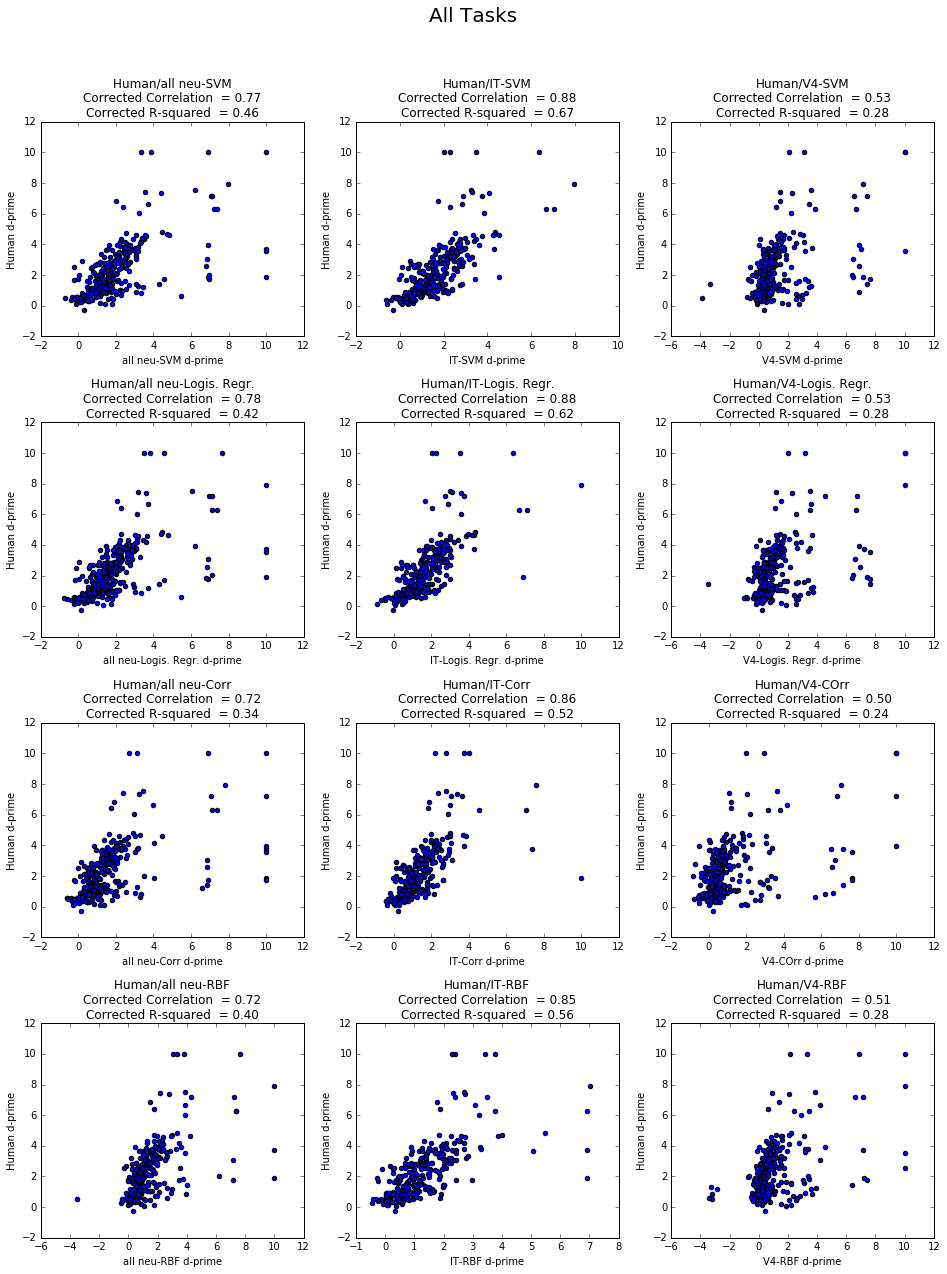

In [371]:
keys = human_confmats.keys()
analyze_relationship(keys)
plt.suptitle('All Tasks', fontsize=20)

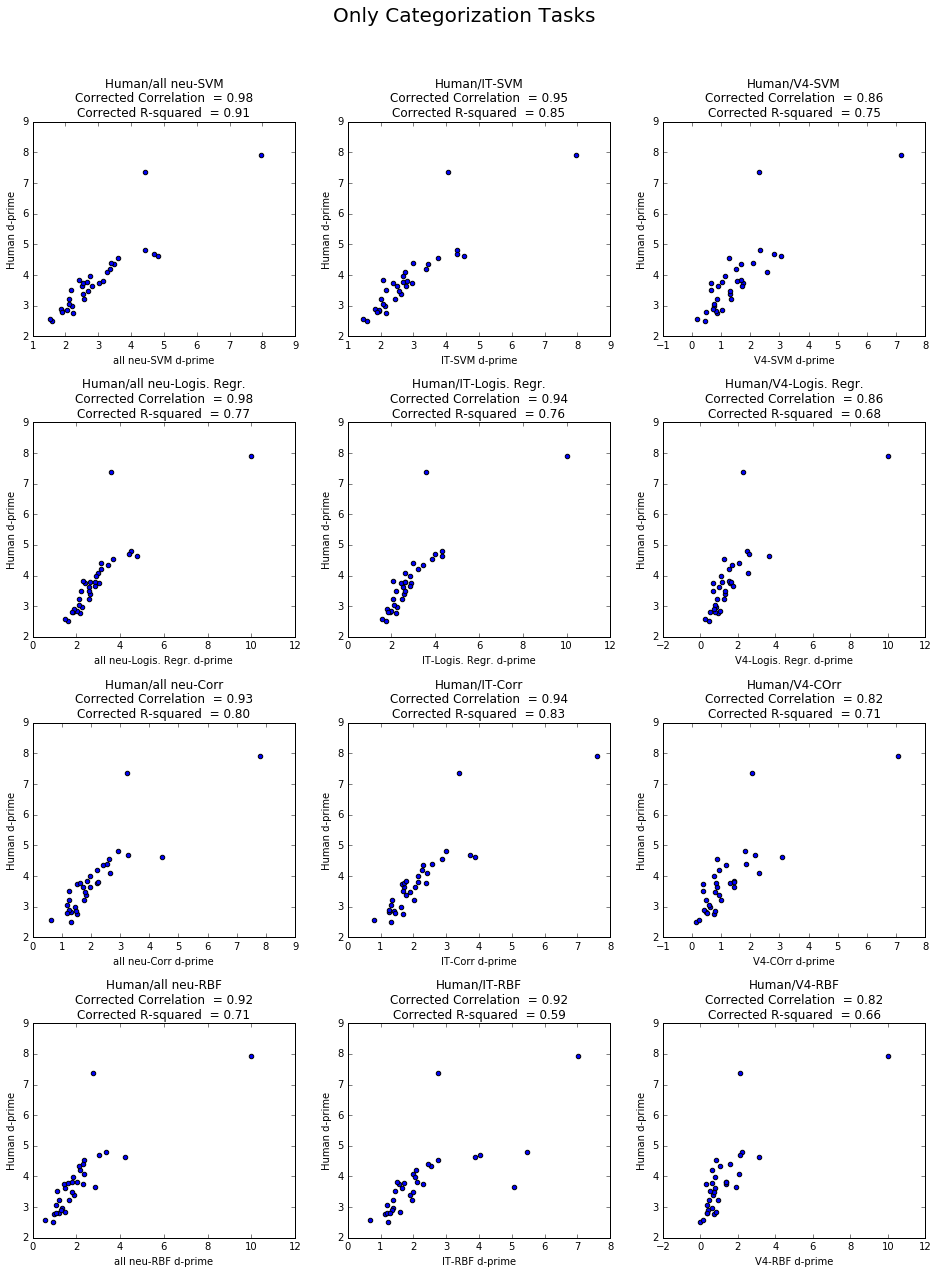

In [372]:
#Only for basic-level categorization tasks 
keys = [x for x in human_confmats.keys() if 'Basic' in x[0]]
analyze_relationship(keys)
plt.suptitle('Only Categorization Tasks', fontsize=20)

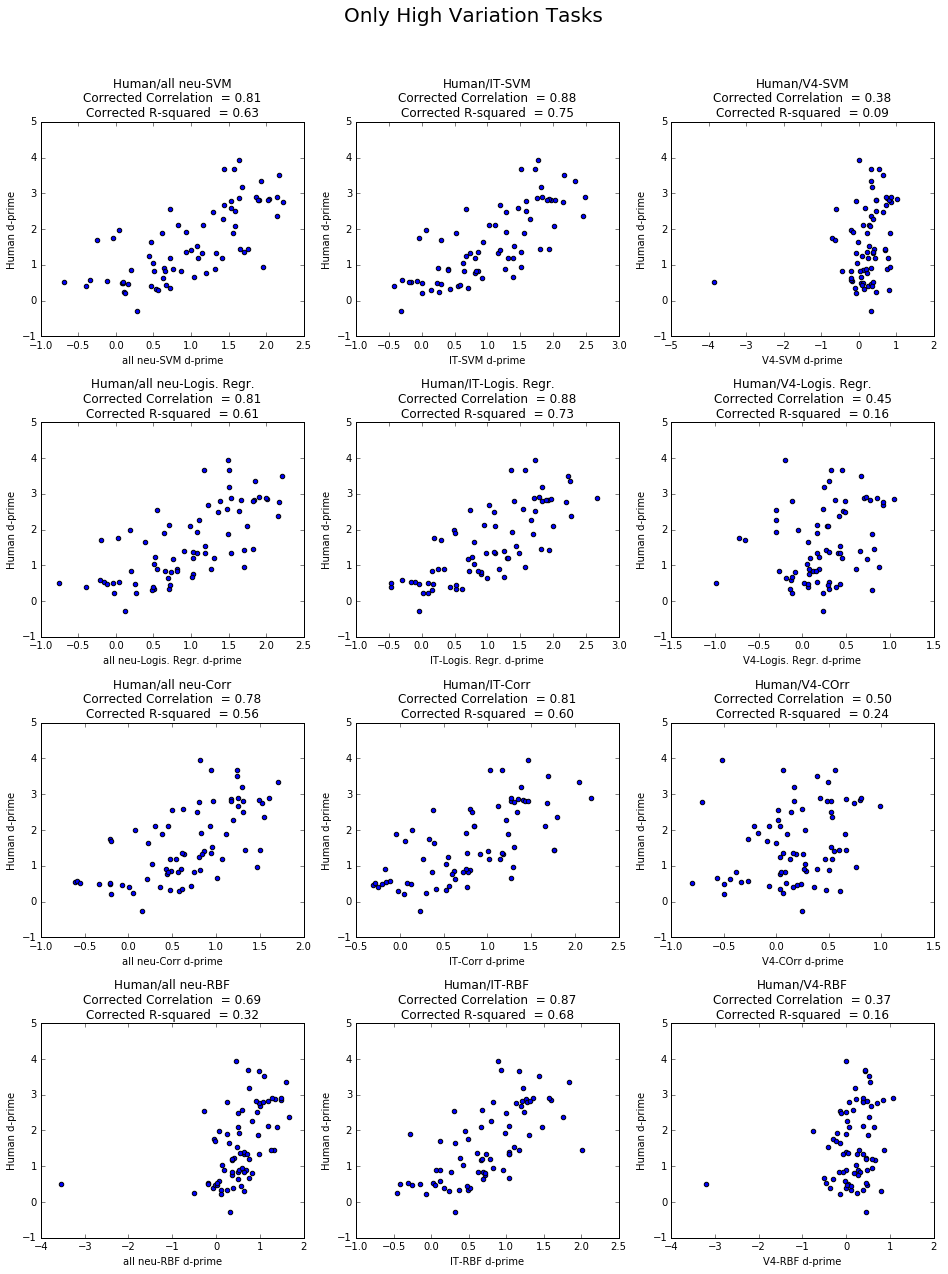

In [373]:
keys = [x for x in human_confmats.keys() if x[1] in ['V6']]
analyze_relationship(keys)
plt.suptitle('Only High Variation Tasks', fontsize=20)

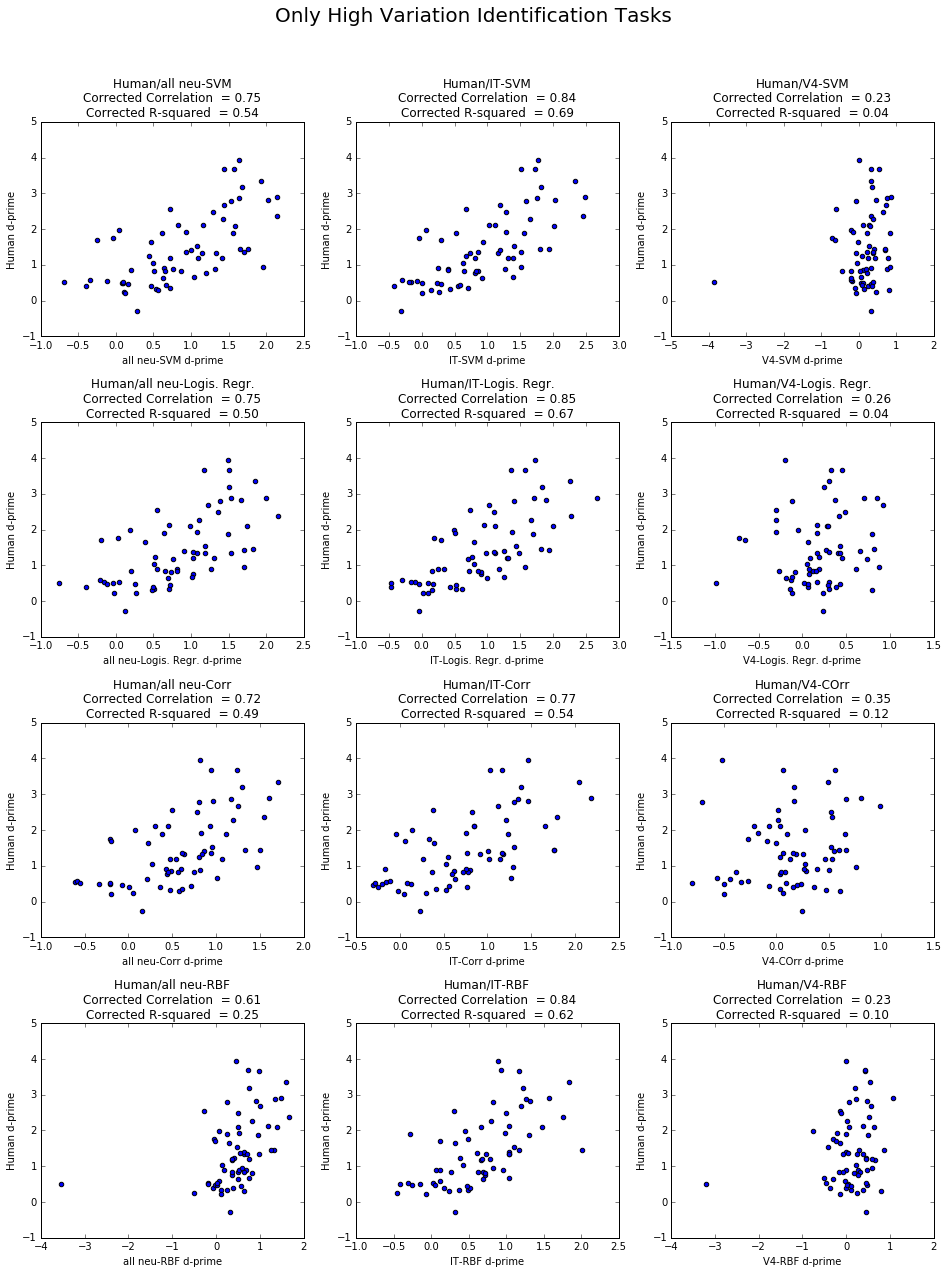

In [374]:
keys = [x for x in human_confmats.keys() if x[1] in ['V6'] and 
        'Basic' not in x[0]]
analyze_relationship(keys)
plt.suptitle('Only High Variation Identification Tasks', fontsize=20)

In [ ]:
cvals = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 
         1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2,
         1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

neural_results_CV = tabulate_results(Neural_Data,                                   LinearSVC, 
                                     gridcv_params={'C': cvals},
                                     toprint=True)

IT_neural_results_CV = tabulate_results(IT_Neural_Data,
                                     LinearSVC,
                                     gridcv_params={'C': cvals})                                   
        
V4_neural_results_CV = tabulate_results(V4_Neural_Data,
                                        LinearSVC,
                                        gridcv_params={'C': cvals})                                  


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 90.27
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 83.21
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 92.14
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 61.79
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 